In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
from scipy.optimize import minimize
import pandas as pd
from IPython.display import display
from scipy.interpolate import UnivariateSpline
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from itertools import product

chart_annotation_font = {
  'family': 'arial',
  'color':  'black',
  'weight': 'normal',
  'size': 10,
  'style': 'italic'
}

## spend values
X_spend = np.linspace( 0, 2_000_000, 10_000 )

## min spend before the log and logistic functions return values
MIN_SPEND = 50_000

## define the revenue functions
def revenue1( s ): return 1.2 * s
def revenue2( s ):
    return np.where( s >= MIN_SPEND, 500_000 * np.log1p( s / 100_000 ), 0 )
def revenue3( s ):
    return np.where( s >= MIN_SPEND, 2_000_000 / ( 1 + np.exp( -0.000005 * ( s - 1_000_000 ) ) ), 0 )

curves = [ 
            ( revenue1( X_spend ), "Revenue = 1.2 × Spend", "Spend-Revenue Curve 1 (Linear)", 'dodgerblue', 'revenue1', revenue1 ),
            ( revenue2( X_spend ), "Revenue = 500k × ln(1 + Spend / 100k)", "Spend-Revenue Curve 2 (Log)", 'maroon', 'revenue2', revenue2 ),
            ( revenue3( X_spend ), "Revenue = 2M / (1 + e^{-0.000005 × (Spend - 1M)})", "Spend-Revenue Curve 3 (Logistic)", 'mediumvioletred', 'revenue3', revenue3 )
]
rho = 1.2

## Waterfall Budgeting Method ##

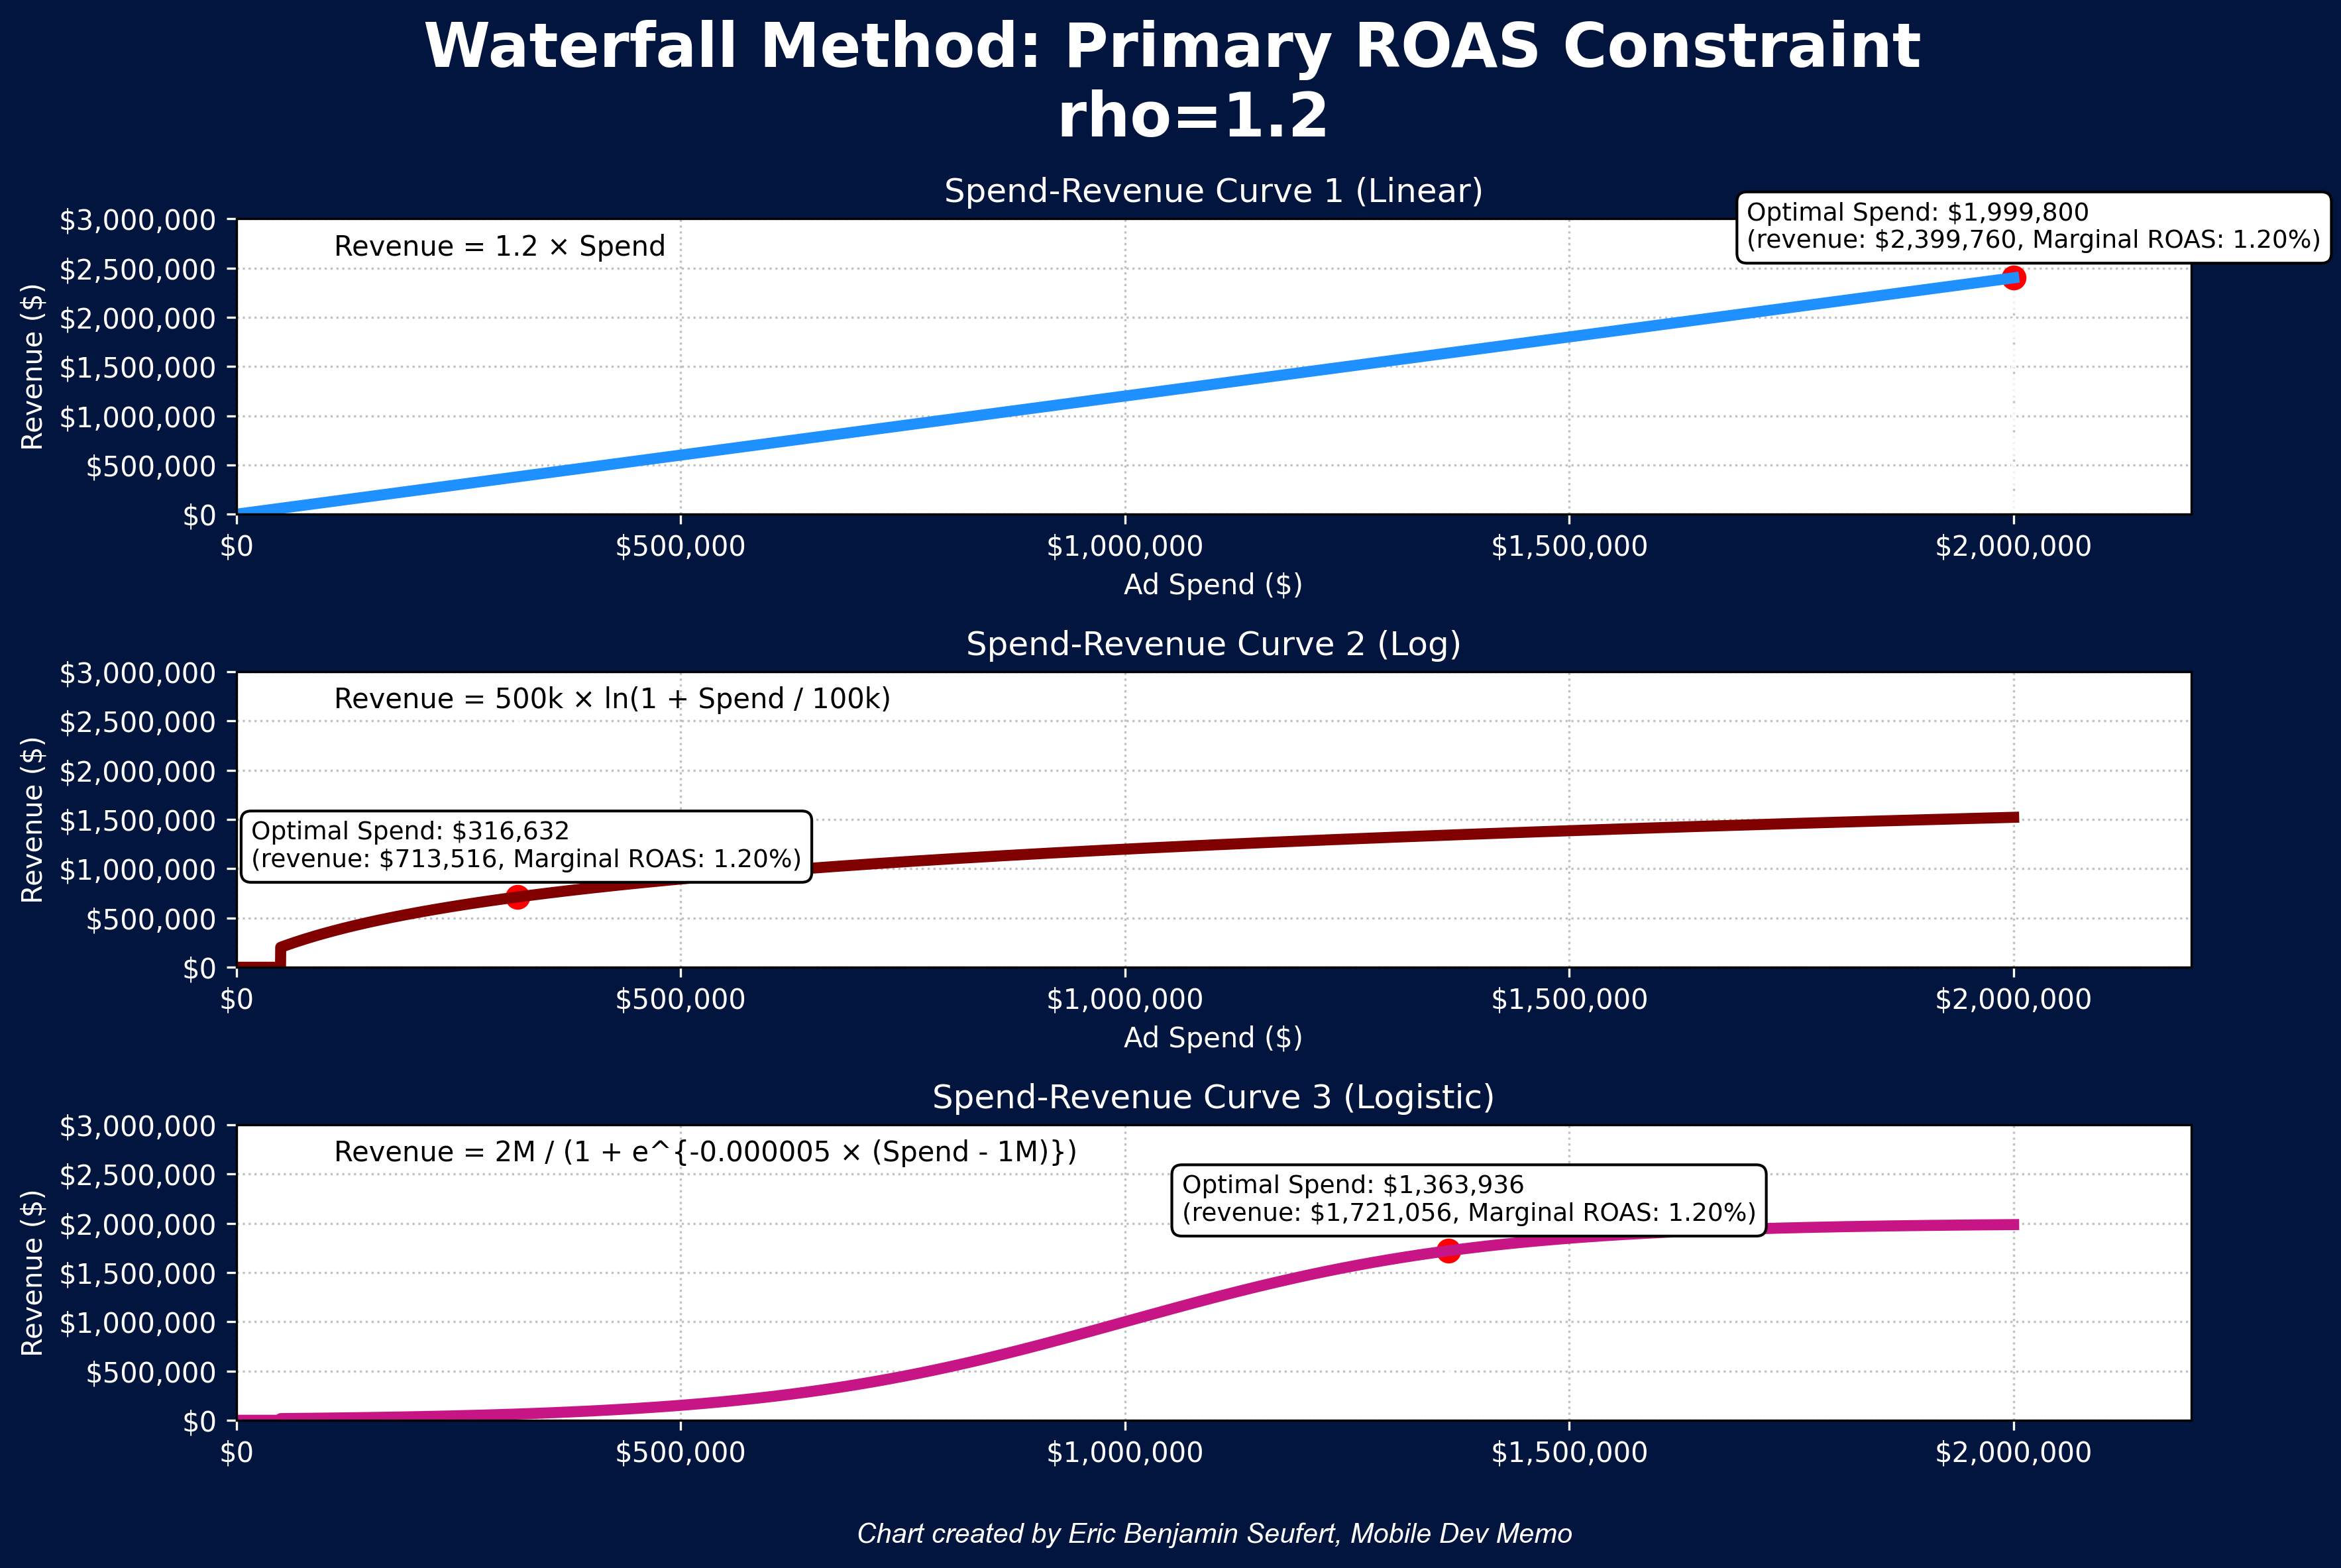

In [2]:
## create the plot
fig, axs = plt.subplots( 3, 1, dpi=300, figsize=( 12, 8 ) )
fig.patch.set_facecolor( 'xkcd:navy' )

for ax, (revenue, eq, title, color, _, _ ) in zip( axs, curves ):

    ## marginal ROAS for the curve
    marginal_roas = np.gradient( revenue, X_spend )

    valid_idxs = np.where( marginal_roas >= rho )[ 0 ]

    if len( valid_idxs ) > 0:
        i = valid_idxs[ -1 ]
        optimal_spend = X_spend[ i ]
    else:
        optimal_spend = 0.0

    optimal_revenue = revenue[ i ]
    
    ## mark the optimal spend amount
    ax.axvline( x=optimal_spend, color='white', linestyle='--', linewidth=2, alpha=0.8 )
    ## annotate
    ax.text(
        optimal_spend - 300_000,
        optimal_revenue + 250_000, 
        f'Optimal Spend: ${optimal_spend:,.0f} \n(revenue: ${optimal_revenue:,.0f}, Marginal ROAS: {marginal_roas[ i ]:,.2f}%)', 
        fontsize=9,
        color='black',
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4')
    )
    ## red marker
    ax.plot( optimal_spend, optimal_revenue, 'o', color='red', markersize=8 )
    ax.plot( X_spend, revenue, linewidth=4, color=color )
    ax.set_title( title, color='white', fontsize=12 )
    ax.set_xlabel( "Ad Spend ($)", color='white' )
    ax.set_ylabel( "Revenue ($)", color='white' )
    ax.tick_params( axis='x', colors='white' )
    ax.tick_params( axis='y', colors='white' )
    ax.set_xlim( 0, 2_200_000 )
    ax.set_ylim( 0, 3_000_000 )
    ax.xaxis.set_major_locator( mtick.MultipleLocator( 500_000 ) )
    ax.yaxis.set_major_locator( mtick.MultipleLocator( 500_000 ) )
    ax.xaxis.set_major_formatter( mtick.StrMethodFormatter('${x:,.0f}' ) )
    ax.yaxis.set_major_formatter( mtick.StrMethodFormatter('${x:,.0f}' ) )
    ax.text( 0.05, 0.95, eq, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', color='black' )
    ax.grid( True, which='both', color='xkcd:charcoal', linewidth=0.8, linestyle=':', alpha=.3 )

axs[ 2 ].set_xlabel(
    "Chart created by Eric Benjamin Seufert, Mobile Dev Memo",
    fontdict=chart_annotation_font,
    labelpad=20,
    color="white"
)

fig.suptitle( "Waterfall Method: Primary ROAS Constraint \n rho=1.2", weight='bold', color='white', fontsize=22)
plt.tight_layout()
plt.show()

## Distributed Budgeting Method ##

In [3]:
## splits curves into segments where average ROAS >= rho
## not used
def split_curves_by_average_ROAS( curves ):
    split_curves = {}
    for f, formula, label, color, name, curve in curves:
        split_curves[ name ] = {
            'curve': curve,
            'color': color,
            'label': label,
            'formula': formula,
            'parent': name,
            'valid_domains': []
        }
        this_domain = []
        for x in X_spend:
            if x > 0 and curve(x) / x >= rho:
                this_domain.append( x )
            else:
                if len( this_domain ) > 1:
                    domain_bounds = ( this_domain[ 0 ], this_domain[ -1 ] )
                    split_curves[ name ]['valid_domains'].append(domain_bounds)
                this_domain = []

        if len( this_domain ) > 1:
            domain_bounds = ( this_domain[ 0 ], this_domain[ -1 ] )
            split_curves[ name ][ 'valid_domains' ].append( domain_bounds )
                    
    return split_curves

## splits curves into segments where marginal ROAS >= rho
## not used
def split_curves_by_marginal_ROAS(curves):
    split_curves = {}

    for f, formula, label, color, name, curve in curves:
        revenue = np.array( [ curve( x ) for x in X_spend ] )
        marginal_roas = np.gradient( revenue, X_spend )
        average_roas = np.array( [ curve( x ) / x if x > 0 else 0 for x in X_spend ] )
        valid_mask = ( marginal_roas >= rho ) & ( average_roas >= rho )

        split_curves[name] = {
            'curve': curve,
            'color': color,
            'label': label,
            'formula': formula,
            'parent': name,
            'valid_domains': []
        }

        this_domain = []
        for i, is_valid in enumerate( valid_mask ):
            if is_valid:
                this_domain.append( X_spend[ i ] )
            else:
                if len( this_domain ) > 1:
                    domain_bounds = ( this_domain[ 0 ], this_domain[ -1 ] )
                    split_curves[ name ][ 'valid_domains' ].append( domain_bounds )
                this_domain = []

        if len( this_domain ) > 1:
            domain_bounds = ( this_domain[ 0 ], this_domain[ -1 ] )
            xs = np.linspace( *domain_bounds, 100 )
            roas_vals = np.gradient( [ curve( x ) for x in xs ], xs )
            if np.all( roas_vals >= rho ):
                split_curves[ name ][ 'valid_domains' ].append( domain_bounds )
            else:
                print( "Bound violation." )

    return split_curves

## this ultimately just formats the curves into a dict
## it isn't strictly necessary but the pipeline would need to be rewritten without it
def split_curves_no_filter( curves ):
    split_curves = {}

    for f, formula, label, color, name, curve in curves:
        split_curves[ name ] = {
            'curve': curve,
            'color': color,
            'label': label,
            'formula': formula,
            'parent': name,
            'valid_domains': [ ( min( X_spend ), max( X_spend ) ) ]
        }

    return split_curves

## constraint factories
def make_budget_constraint_exact():
    return {
        'type': 'eq',
        'fun': lambda x_t: np.sum(x_t[:N]) - x_t[-1] * MAX_BUDGET
    }

def make_spend_bounds( i, spend_min, spend_max ):
    return [
        {'type': 'ineq', 'fun': lambda x_t, i=i: x_t[i] / x_t[-1]},  # >= 0
        {'type': 'ineq', 'fun': lambda x_t, i=i: spend_max - x_t[i] / x_t[-1]}
    ]

MAX_BUDGET = 2_000_000
#split_curves = split_curves_by_average_ROAS( curves )
#split_curves = split_curves_by_marginal_ROAS( curves )
split_curves = split_curves_no_filter( curves )

parent_segments = {}
for name, meta in split_curves.items():
    parent_segments[ name ] = []
    for i, ( spend_min, spend_max ) in enumerate( meta[ 'valid_domains' ] ):
        parent_segments[name].append( (
            f"{name}_{i+1}",
            name,
            meta['curve'],
            spend_min,
            spend_max
        ) )

## generate all combinations of curves
## in reality, there are only 3 curves
## but if the other split_curves functions are used, each curve can be split
## into valid segments
all_combinations = list( product( *parent_segments.values() ) )

best_result = None
best_roas = -float( 'inf' )

for segment_combo in all_combinations:
    revenue_functions = list( segment_combo )
    N = len( revenue_functions )

    def transformed_objective( x_t ):
        x = x_t[ :N ]
        t = x_t[ -1 ]
        if t <= 0:
            return 1e9
        revenue_sum = 0
        for i in range( N ):
            spend = x[ i ] / t
            revenue_sum += revenue_functions[ i ][ 2 ]( spend )
        return -revenue_sum

    ## apply the constraints
    constraints = [ make_budget_constraint_exact() ]
    for i in range( N ):
        spend_min, spend_max = revenue_functions[ i ][ 3 ], revenue_functions[ i ][ 4 ]
        constraints += make_spend_bounds( i, spend_min, spend_max )

    ## set bounds and seed the x0 values with reasonable estimates (midpoint)
    t_min = 1 / MAX_BUDGET * 10
    bounds = [ ( 0, None ) ] * N + [ ( 1e-8, None ) ]

    x0_vals = []
    for _, _, _, spend_min, spend_max in revenue_functions:
        if spend_max > spend_min:
            midpoint = ( spend_min + spend_max ) / 2
        else:
            midpoint = 0
        x0_vals.append( midpoint )
    x0 = x0_vals + [ 1.0 ]

    print( f"Trying combination: {[s[0] for s in segment_combo]}" )
    print( f"Spend bounds: {[s[3:5] for s in segment_combo]}" )
    print( f"Initial guess: {x0}" )
    print( f"Budget constraint t_min: {t_min}" )
    print( "-----------" )
    
    result = minimize(
        transformed_objective,
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 10_000, 'ftol': 1e-6, 'disp': True}
    )

    if result.success:
        x_opt = result.x[ :N ]
        t_opt = result.x[ -1 ]
        s_opt = x_opt / t_opt
        r_opt = [ fn[ 2 ]( s ) for fn, s in zip( revenue_functions, s_opt ) ]
        total_spend = s_opt.sum()
        total_revenue = sum( r_opt )
        roas = total_revenue / total_spend if total_spend > 0 else 0

        if roas > best_roas:
            best_roas = roas
            best_result = {
                'segments': revenue_functions,
                'spend': s_opt,
                'revenue': r_opt,
                'total_spend': total_spend,
                'total_revenue': total_revenue,
                'roas': roas
            }
    else:
        print( "Optimization failed for combination:", result.message )

## output
df = pd.DataFrame({
    'Segment': [ seg[ 0 ] for seg in best_result[ 'segments' ] ],
    'Parent': [ seg[ 1 ] for seg in best_result[ 'segments' ] ],
    'Spend ($)': best_result[ 'spend' ],
    'Revenue ($)': best_result[ 'revenue' ],
    'Avg ROAS': [ r / s if s > 0 else 0 for r, s in zip( best_result[ 'revenue' ], best_result[ 'spend' ] ) ]
})

marginal_roas_values = [
    np.gradient( [ fn[ 2 ]( x ) for x in [ s-1, s, s+1 ] ], [ s-1, s, s+1 ] )[ 1 ]
    for fn, s in zip( best_result[ 'segments' ], best_result[ 'spend' ] )
]

df[ 'Marginal ROAS' ] = marginal_roas_values

print( f"Total spend: ${best_result['total_spend']:,.2f}" )
print( f"Total revenue: ${best_result['total_revenue']:,.2f}" )
pd.set_option( 'display.float_format', '{:,.2f}'.format )
display( df[ ['Segment', 'Parent', 'Spend ($)', 'Revenue ($)', 'Avg ROAS', 'Marginal ROAS' ] ] )

Trying combination: ['revenue1_1', 'revenue2_1', 'revenue3_1']
Spend bounds: [(0.0, 2000000.0), (0.0, 2000000.0), (0.0, 2000000.0)]
Initial guess: [1000000.0, 1000000.0, 1000000.0, 1.0]
Budget constraint t_min: 4.9999999999999996e-06
-----------
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2815321.760327538
            Iterations: 48
            Function evaluations: 299
            Gradient evaluations: 48
Total spend: $2,000,000.00
Total revenue: $2,815,321.76


,Segment,Parent,Spend ($),Revenue ($),Avg ROAS,Marginal ROAS
0,revenue1_1,revenue1,"280,503.01","336,603.61",1.20,1.20
1,revenue2_1,revenue2,"359,962.32",762987.1954322698,2.12,1.09
2,revenue3_1,revenue3,"1,359,534.67",1715730.9588691224,1.26,1.22


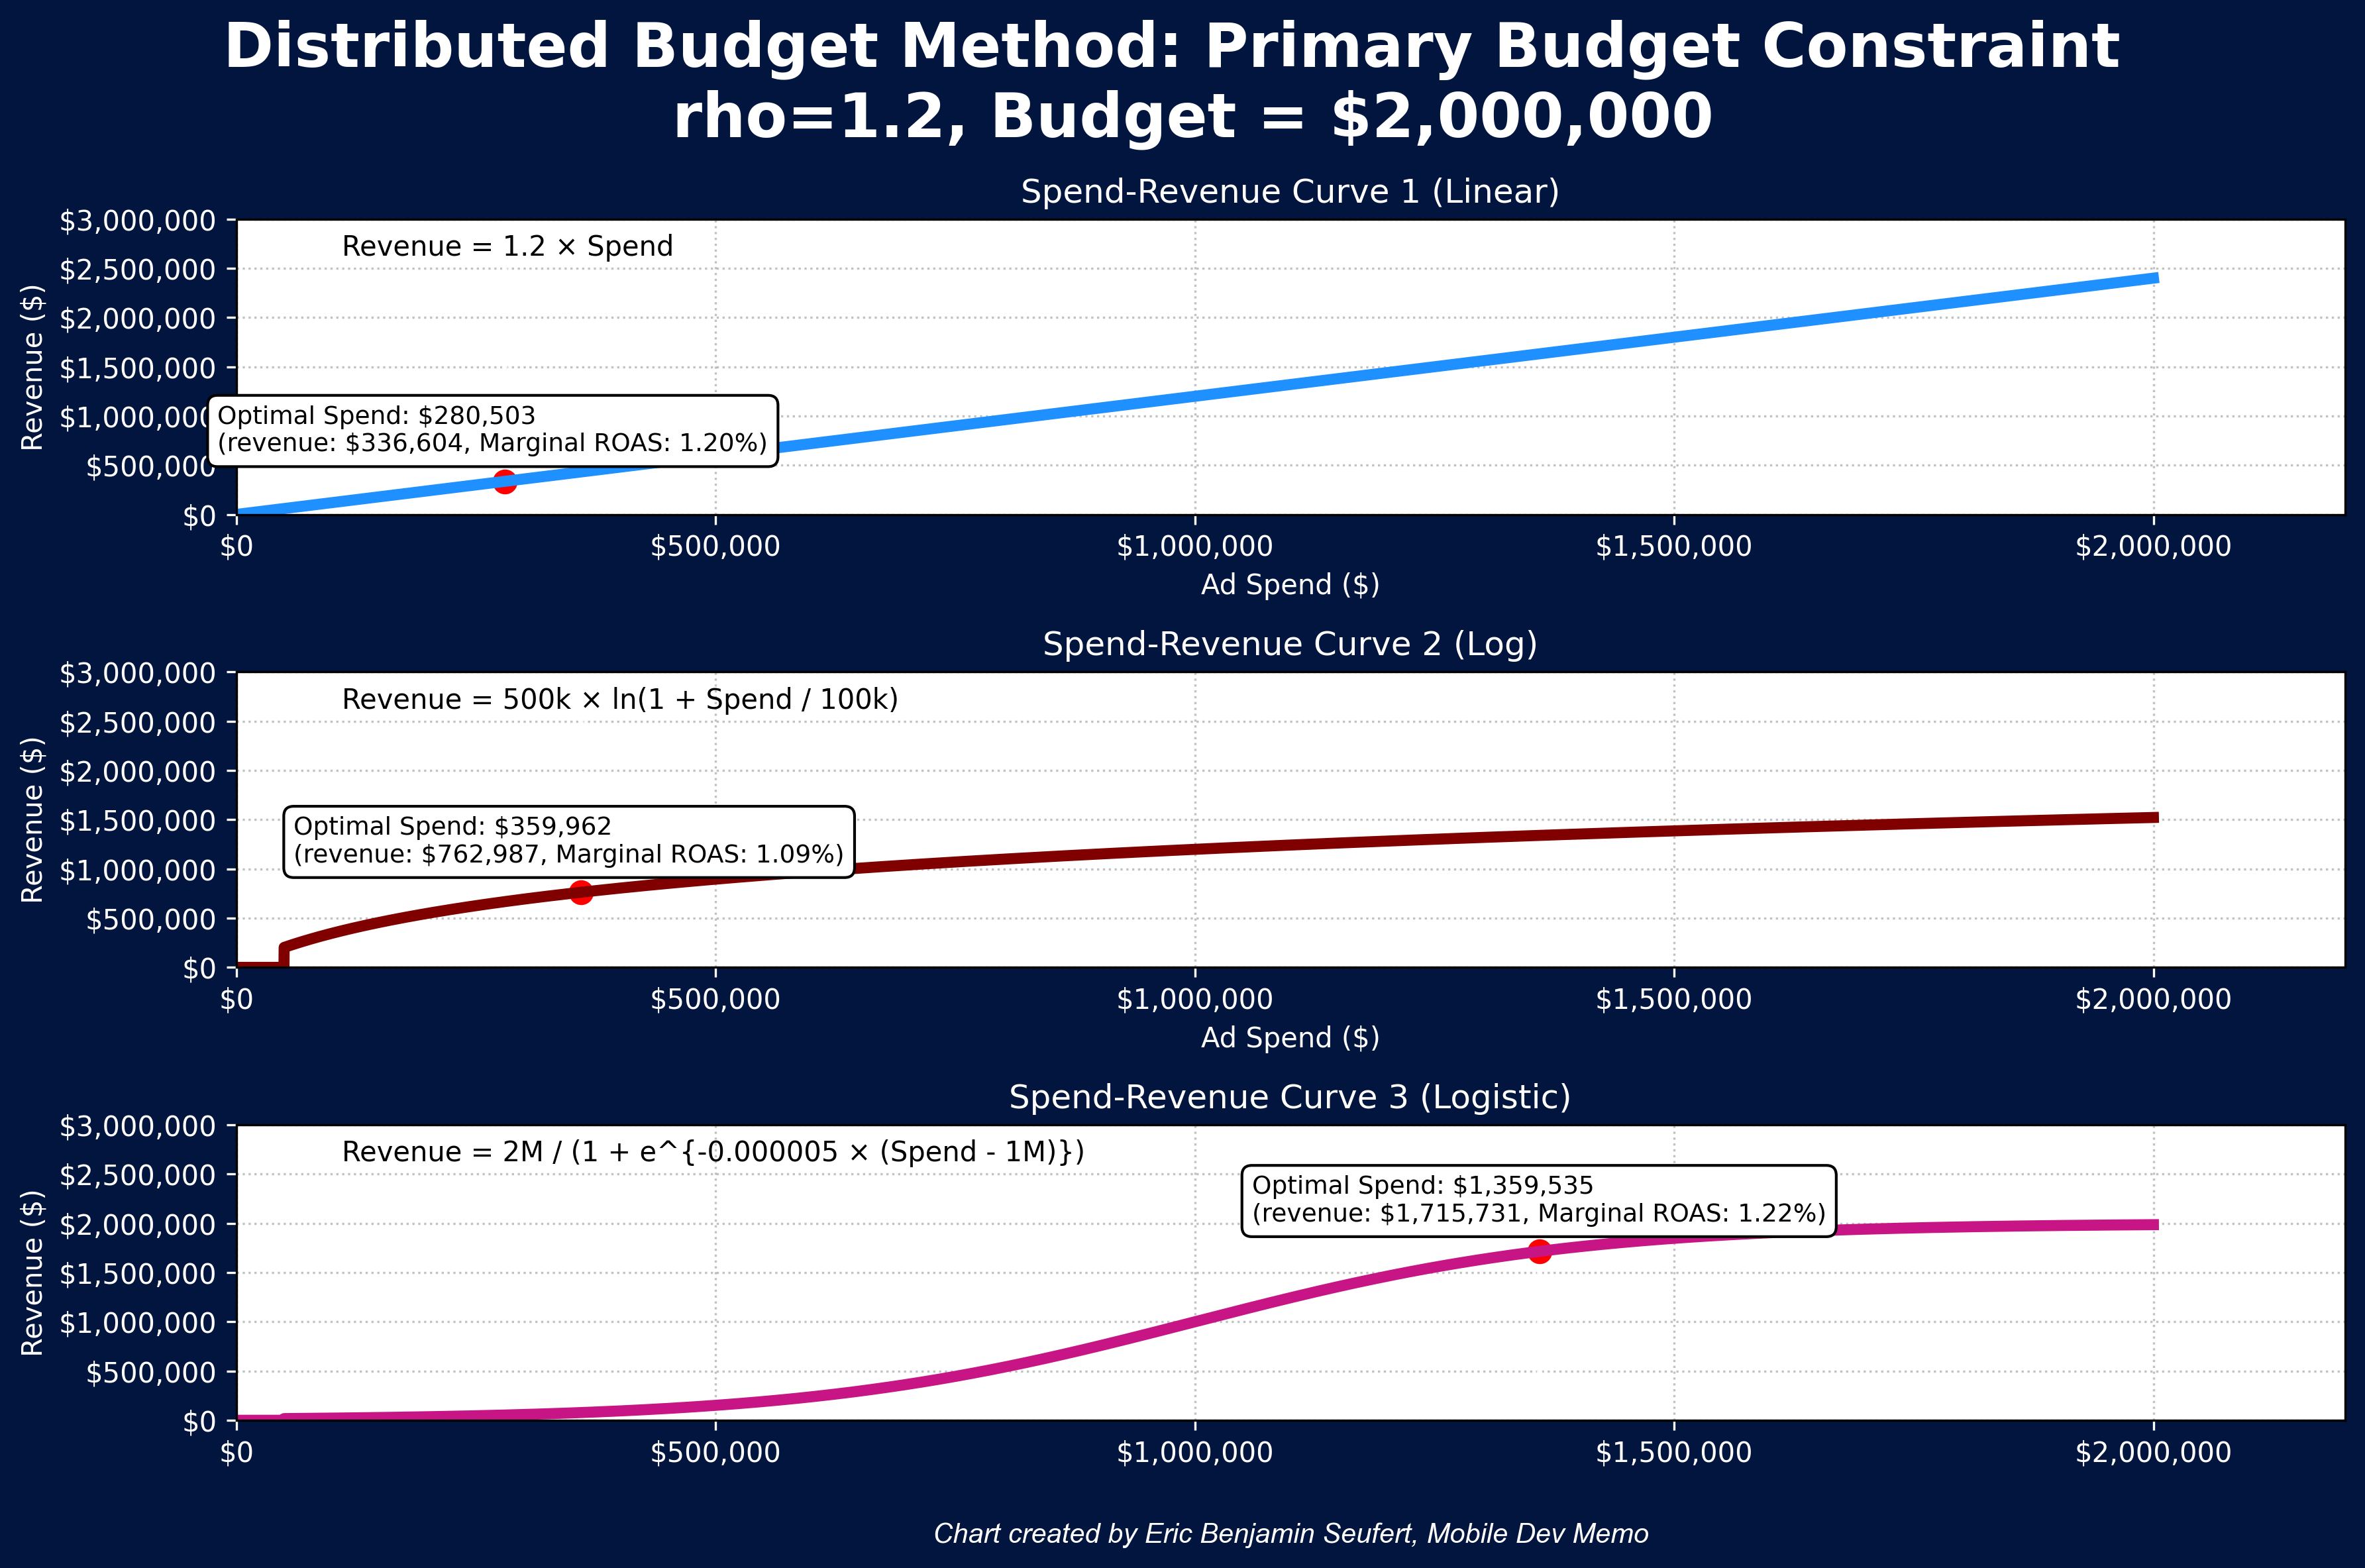

In [4]:
## chart distributed budget method results
fig, axs = plt.subplots( 3, 1, dpi=300, figsize=( 12, 8 ) )
fig.patch.set_facecolor( 'xkcd:navy' )

for ax, (revenue, eq, title, color, name, _ ) in zip( axs, curves ):    
    ## mark the optimal spend amount
    df_parent = df[df['Parent'] == name]
    if df_parent.empty:
        continue
    
    optimal_spend = df_parent['Spend ($)'].values[0]
    optimal_revenue = df_parent['Revenue ($)'].values[0]
    marginal_roas = df_parent['Marginal ROAS'].values[0]
    
    ax.axvline( x=optimal_spend, color='white', linestyle='--', linewidth=2, alpha=0.8 )
    ## annotate
    ax.text(
        optimal_spend - 300_000,
        optimal_revenue + 250_000, 
        f'Optimal Spend: ${optimal_spend:,.0f} \n(revenue: ${optimal_revenue:,.0f}, Marginal ROAS: {marginal_roas:,.2f}%)', 
        fontsize=9,
        color='black',
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4')
    )
    ## red marker at optimal spend/revenue
    ax.plot( optimal_spend, optimal_revenue, 'o', color='red', markersize=8 )
    ax.plot( X_spend, revenue, linewidth=4, color=color )
    ax.set_title( title, color='white', fontsize=12 )
    ax.set_xlabel( "Ad Spend ($)", color='white' )
    ax.set_ylabel( "Revenue ($)", color='white' )
    ax.tick_params( axis='x', colors='white' )
    ax.tick_params( axis='y', colors='white' )
    ax.set_xlim( 0, 2_200_000 )
    ax.set_ylim( 0, 3_000_000 )
    ax.xaxis.set_major_locator( mtick.MultipleLocator( 500_000 ) )
    ax.yaxis.set_major_locator( mtick.MultipleLocator( 500_000 ) )
    ax.xaxis.set_major_formatter( mtick.StrMethodFormatter('${x:,.0f}' ) )
    ax.yaxis.set_major_formatter( mtick.StrMethodFormatter('${x:,.0f}' ) )
    ax.text( 0.05, 0.95, eq, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', color='black' )
    ax.grid( True, which='both', color='xkcd:charcoal', linewidth=0.8, linestyle=':', alpha=.3 )

axs[ 2 ].set_xlabel(
    "Chart created by Eric Benjamin Seufert, Mobile Dev Memo",
    fontdict=chart_annotation_font,
    labelpad=20,
    color="white"
)

fig.suptitle( "Distributed Budget Method: Primary Budget Constraint \n rho=1.2, Budget = $2,000,000", weight='bold', color='white', fontsize=22)
plt.tight_layout()
plt.show()

In [5]:
### NOT USED ###

def find_inflection_points( curve ):

    y_vals = np.array( [ curve( s ) for s in X_spend ] )

    # Fit a smooth spline to the data
    spline = UnivariateSpline( X_spend, y_vals, k=2, s=1e3 )

    # Compute second derivative
    d2 = spline.derivative( n=2 )( X_spend )

    # Find sign changes in the second derivative
    sign_changes = np.where(np.diff(np.sign(d2)))[0]

    inflection_points = [ X_spend[ i ] for i in sign_changes ]
    return inflection_points

## split the curves up by inflection points

def split_curves_by_inflection( curves ):
    split_curves = {}
    for f, formula, label, color, name, curve in curves:
        split_curves[ name ] = {
            'curve': curve,
            'color': color,
            'label': label,
            'formula': formula,
            'parent': name
        }
        ip = find_inflection_points( curve )
        split_curves[ name ][ 'num_ip' ] = len( ip )
        split_curves[ name ][ 'curves' ] = []
    
        if len( ip ) == 0:
            split_curves[ name ][ 'curves' ].append( f )
            ## set spend bounds that cover the whole spend range
            split_curves[ name ][ 'spend_bounds' ] = ( X_spend[ 0 ], X_spend[ -1 ] )
        else:
            split_curves[ name ][ 'curves' ] = None
            ## split the curve up by the number of inflection points
            ## create a new value in the split_curves dict
            cut_points = [ 0 ] + [ np.searchsorted( X_spend, value ) for value in ip ] + [ len( X_spend ) ]
            print( cut_points )
            
            for i in range( len( cut_points ) - 1 ):
                ip_name = name + '_' + str( i+1 )
                split_curves[ ip_name ] = split_curves[ name ].copy()
                split_curves[ ip_name ][ 'curves' ] = []
                ## get the revenue and spend data
                start = cut_points[ i ]
                end = cut_points[ i + 1 ]
                spend_data = X_spend[ start : end ]
                revenue_data = f[ start : end ]
                ## create a curve from the segment
                spline = UnivariateSpline( spend_data, revenue_data, k=3, s=0 )
                ## assign it
                split_curves[ ip_name ][ 'curve' ] = spline
                ## provide the revenue values
                split_curves[ ip_name ][ 'curves' ] = revenue_data
                ## deifne bounds based on where the split happened
                split_curves[ ip_name ][ 'spend_bounds' ] = ( spend_data[ 0 ], spend_data[ -1 ] )
    return split_curves

split_curves = split_curves_by_inflection( curves )
[ ( key, split_curves[ key ][ 'parent' ], split_curves[ key ][ 'curve' ] ) for key in split_curves.keys() if split_curves[ key ][ 'curve' ] is not None ]

[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

/Users/ericseufert/Desktop/CODE/venv/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


error: (m>k) failed for hidden m: fpcurf0:m=0